In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score

In [3]:
def get_num_groups(values):

    # Convert the list to a numpy array
    X = np.array(values).reshape(-1, 1)

    # Silhouette Score
    silhouette_scores = []
    for k in range(2, len(values)):
        kmeans = KMeans(n_clusters=k)
        clusters = kmeans.fit_predict(X)
        silhouette_scores.append(silhouette_score(X, clusters))

    # Elbow Method
    inertia_values = []
    for k in range(1, len(values) + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        inertia_values.append(kmeans.inertia_)

    plt.plot(range(1, len(values) + 1), inertia_values, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.show()

    # Find the optimal number of clusters based on the silhouette score
    optimal_num_clusters = np.argmax(silhouette_scores) + 2  # Add 2 because silhouette score starts from 2 clusters
    print("Optimal number of clusters (Silhouette Score):", optimal_num_clusters)
    
    return optimal_num_clusters

In [4]:
def get_groups(values, k, df):
    # Convert the list to a numpy array
    X = np.array(values).reshape(-1, 1)

    # Define the number of clusters (2 in this case, for the two groups)
    n_clusters = k

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters,n_init="auto",random_state=42)
    kmeans.fit(X)

    # Get the cluster labels
    cluster_labels = kmeans.labels_

    # Initialize lists for each cluster
    clusters = [[] for _ in range(n_clusters)]

    # Assign each value to its corresponding cluster
    for value, label in zip(values, cluster_labels):
        clusters[label].append(value)

    # Print the clusters
    outs=[]
    for i, cluster in enumerate(clusters):
        #print(f"Cluster {i + 1}: {cluster}")
        out_start=df[df["pos"]==min(cluster)]["start"].tolist()[0]
        out_end=df[df["pos"]==max(cluster)]["end"].tolist()[0]
        outs.append([out_start, out_end])
        
    return sorted(outs, key=lambda x: x[0])


In [5]:
lens=[500,1000,5000,10000]
mtype="snp"
all_chrs=["NW_022145594.1" ,"NW_022145594.1" ,"NW_022145597.1" ,"NW_022145600.1" ,"NW_022145601.1" ,"NW_022145603.1" ,"NW_022145606.1" ,"NW_022145609.1" ,"NW_022145610.1"]
chrom=all_chrs[0]

In [6]:
def get_figs(size, m, ax):
    
    route="~/WGS/inversion_results/lostruct_results/type_" + mtype + "_size_" + str(size) + "_chromosome_" + chrom
    coords = pd.read_csv(route + "/" + chrom + ".regions.csv")
    mds = pd.read_csv(route + "/mds_coords.csv")
    lpca = coords.join(mds["MDS1"])
    lpca = lpca.join(mds["MDS2"])
    lpca["pos"] = (lpca["end"]+lpca["start"])/2
    lpca["pos"] = lpca["pos"].astype(int)
    
    if abs(lpca[m].max()) > abs(lpca[m].min()):
        thr = 0.1
        outs = lpca[lpca[m]>=thr]
    else:
        thr = -0.1
        outs = lpca[lpca[m]<=thr]

    print(len(outs))
    if len(outs) >= 2:

        ax.plot(lpca["pos"], lpca[m], ".") #plotting window middle points
        ax.plot(outs["pos"], outs[m], ".")
        ax.axhline(thr, color="red")
        
        all_regions=[]
        for k in range(2):
            int_regions=get_groups(outs["pos"].tolist(), k+1, lpca)
            
            if True:
                if k == 0:
                    linestyle="--"
                    ax.axvline(int_regions[0][0], linestyle=linestyle, color="black")
                    ax.axvline(int_regions[0][1], linestyle=linestyle, color="black")
                else:
                    linestyle=":"
                    ax.axvline(int_regions[0][0], linestyle=linestyle, color="black")
                    ax.axvline(int_regions[0][1], linestyle=linestyle, color="black")
                    ax.axvline(int_regions[1][0], linestyle=linestyle, color="black")
                    ax.axvline(int_regions[1][1], linestyle=linestyle, color="black")
                
            all_regions.append(int_regions)
        
        print(all_regions)
        ax.text(1, 1, all_regions,
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            color='black', fontsize=8) #actual genomic coordinates, not middle points!
        
        ax.set_title(m+" Window size: "+str(size),fontsize=8)
        

10
[[[12702886, 16793794]], [[12702886, 13424367], [15422748, 16793794]]]
6
[[[12614568, 16793794]], [[12614568, 13424367], [15422748, 16793794]]]
3
[[[12358592, 17074638]], [[12358592, 14994318], [14994326, 17074638]]]
2
[[[12358592, 17402012]], [[12358592, 14994318], [14994326, 17402012]]]
47
[[[39429440, 42445994]], [[39429440, 40844618], [41389733, 42445994]]]
26
[[[39909180, 42618545]], [[39909180, 40941391], [41389733, 42618545]]]
7
[[[39268614, 42561530]], [[39268614, 41389713], [41389733, 42561530]]]
4
[[[38118853, 42561530]], [[38118853, 41852289], [41852296, 42561530]]]


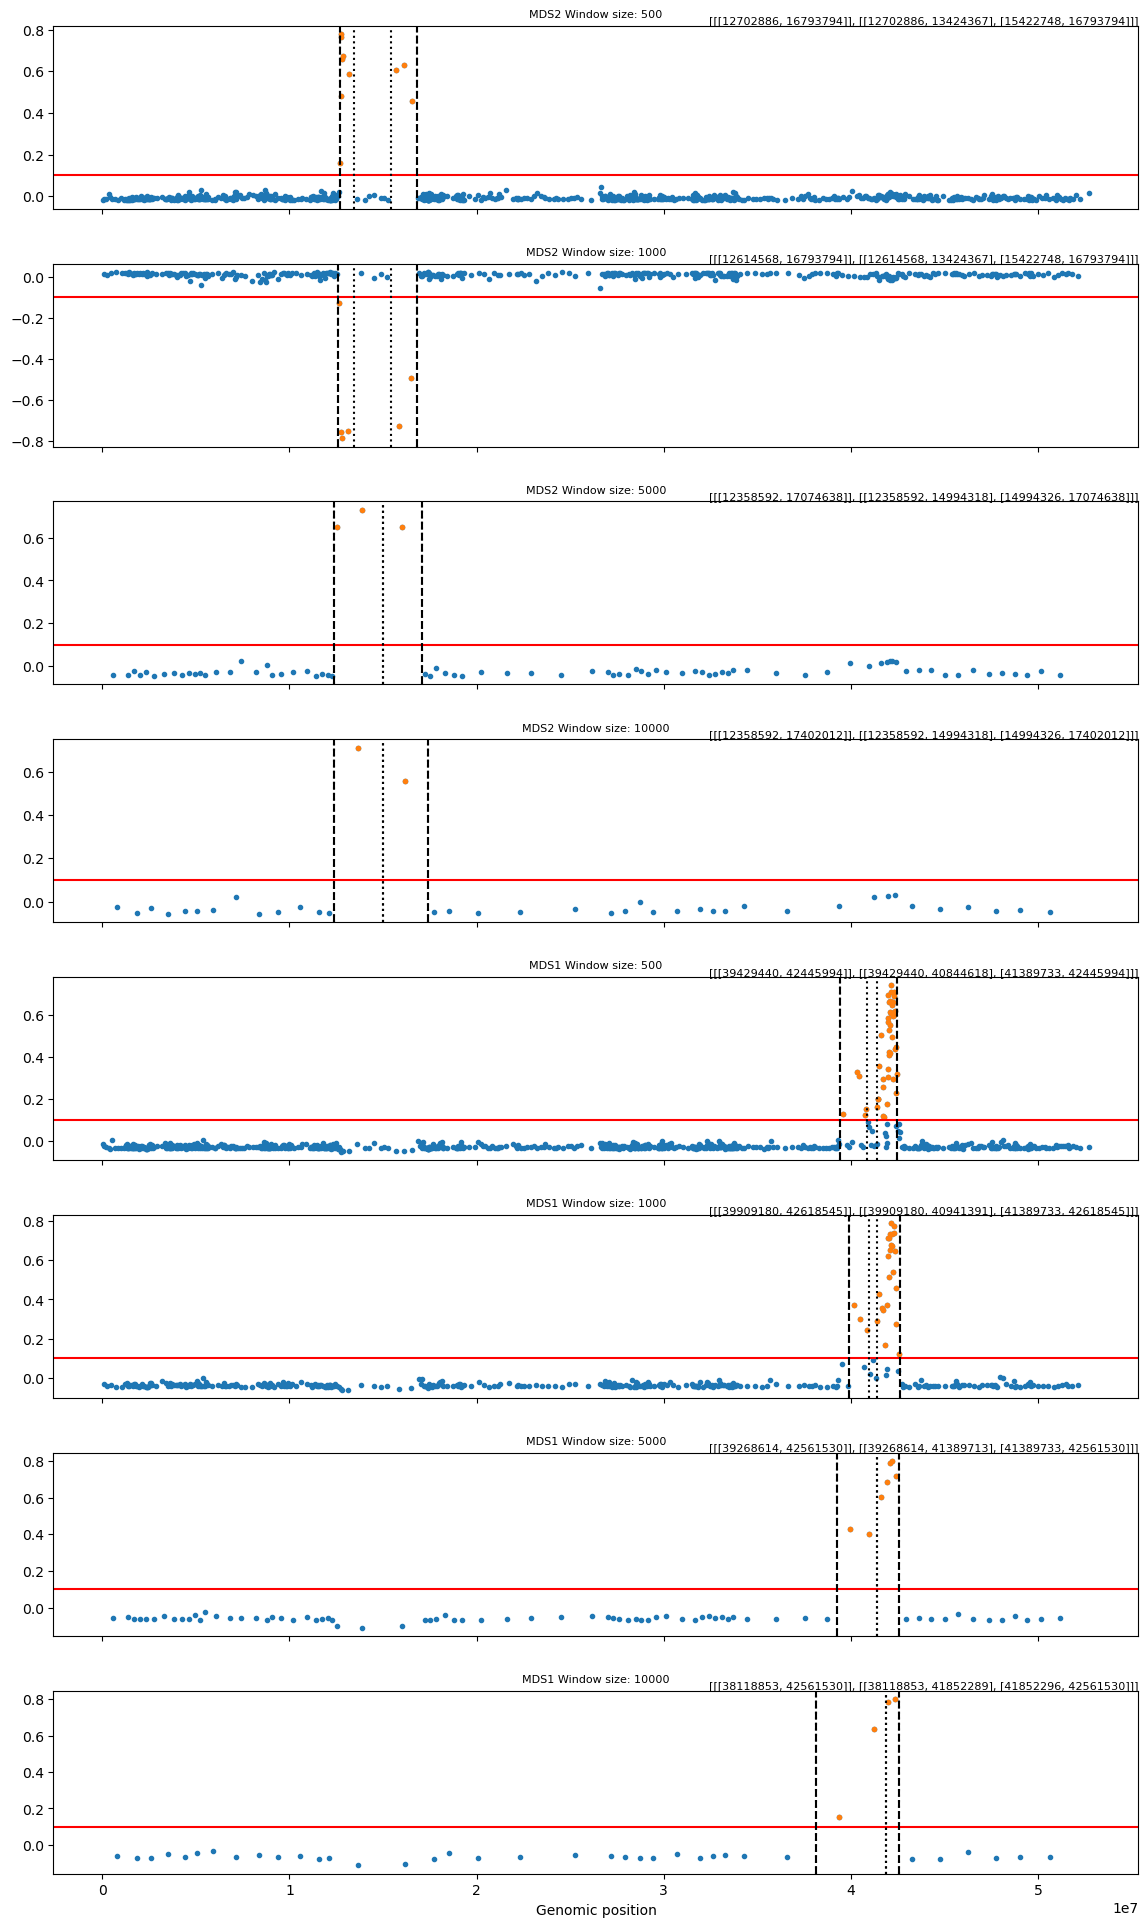

In [7]:
f, axs = plt.subplots(8,1,figsize=(14, 24),sharex=True)

lens=[500,1000,5000,10000]
c=0
for m in ["MDS2","MDS1"]:
    for l in lens:
        get_figs(l,m,axs[c])
        c+=1
plt.subplots_adjust(hspace=0.3)
plt.xlabel("Genomic position")
fname="outlier_regions_"
#plt.savefig(fname+ mtype + "_chromosome_" + chrom+"nb3.pdf")
#get_figs(500,axs,"MDS2")

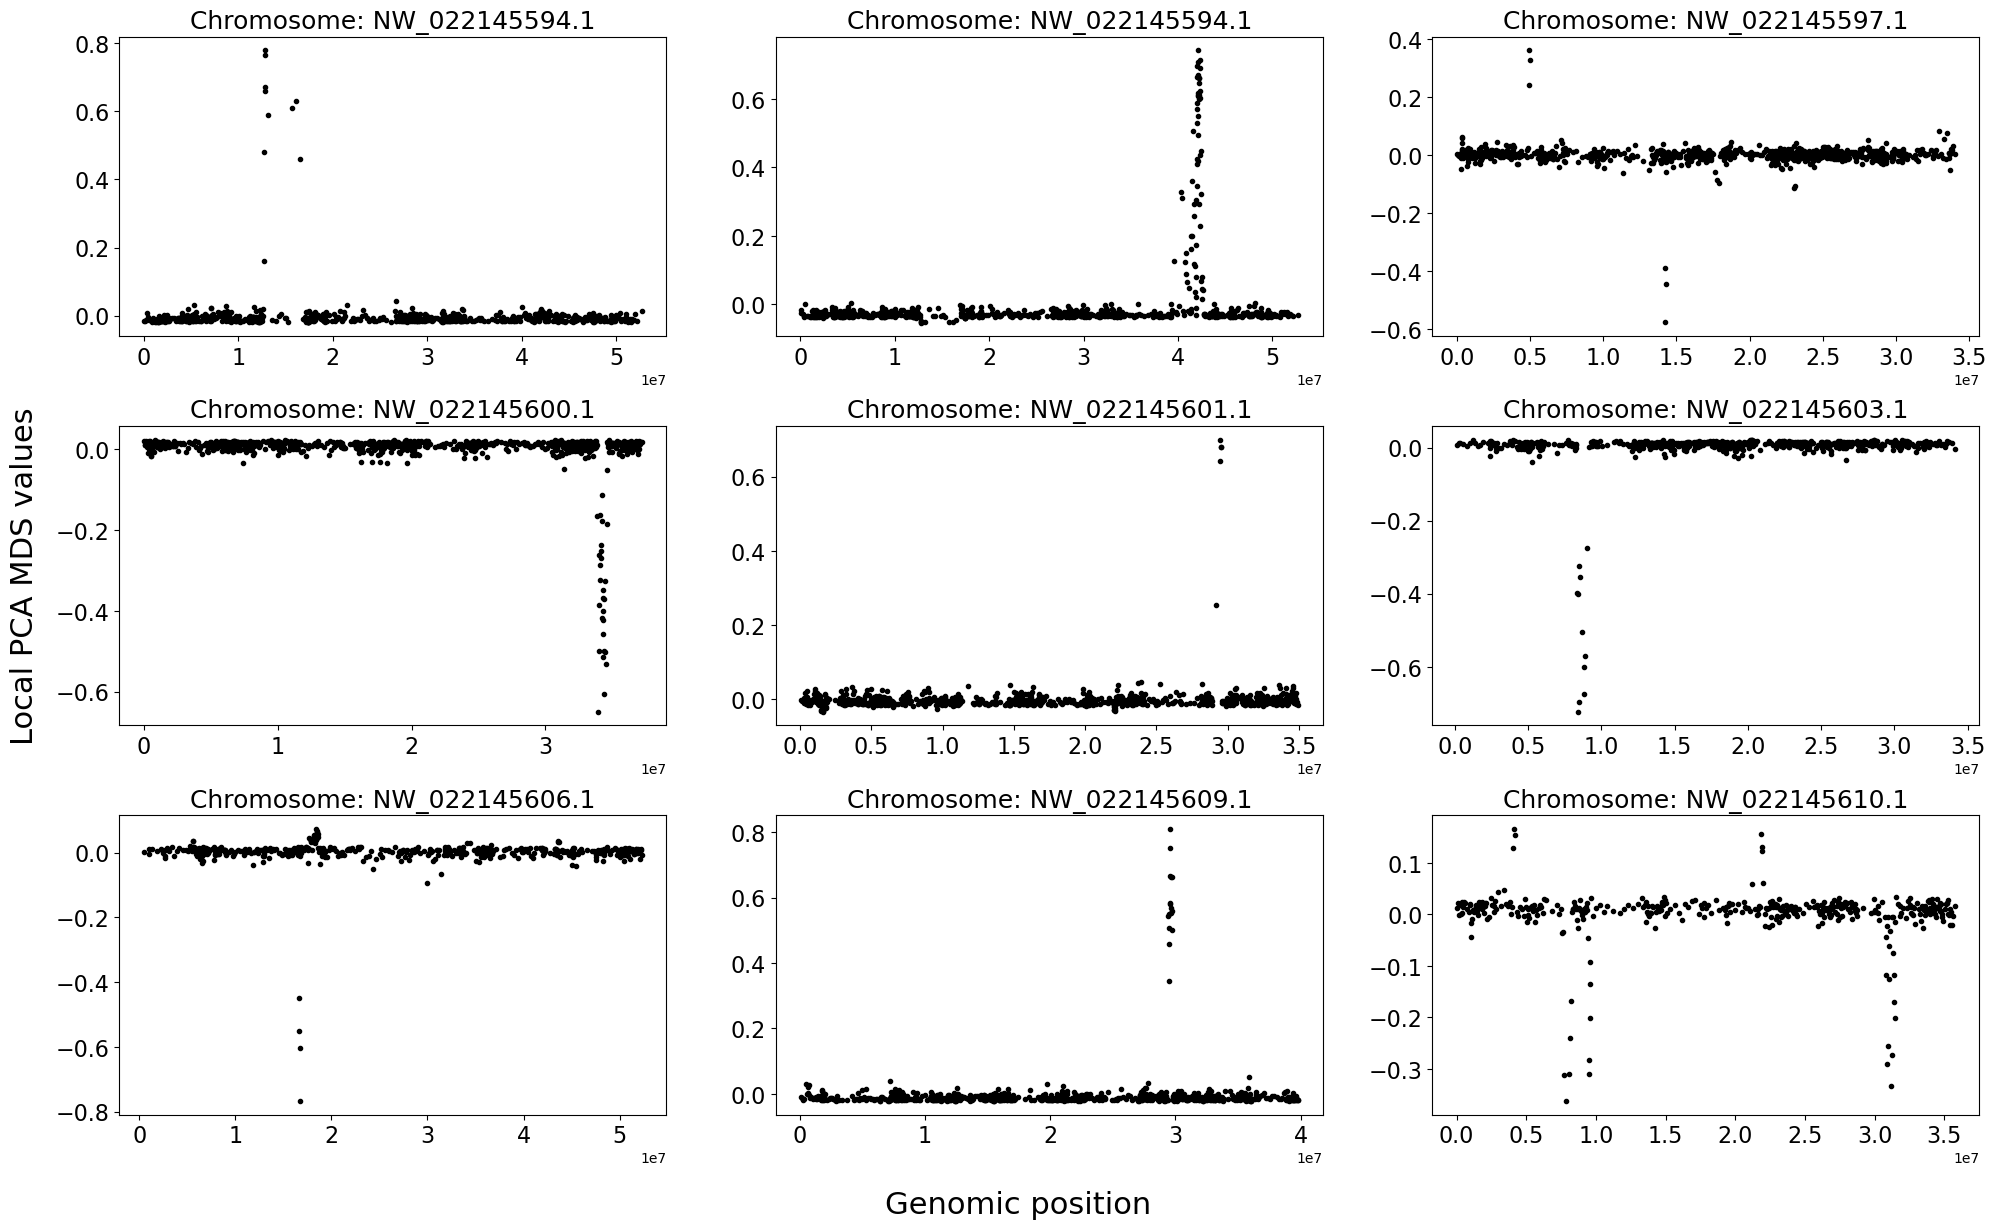

In [8]:
f, axs = plt.subplots(3,3,figsize=(24, 14),sharex=False, sharey=False)

axs=axs.flatten()

counter=0
for c in all_chrs:

    if counter == 8:
        route="~/WGS/inversion_results/lostruct_results/type_" + mtype + "_size_" + str(1000) + "_chromosome_" + c
    else:
        route="~/WGS/inversion_results/lostruct_results/type_" + mtype + "_size_" + str(500) + "_chromosome_" + c
    coords = pd.read_csv(route + "/" + c + ".regions.csv")
    mds = pd.read_csv(route + "/mds_coords.csv")
    lpca = coords.join(mds["MDS1"])
    lpca = lpca.join(mds["MDS2"])
    lpca["pos"] = (lpca["end"]+lpca["start"])/2
    lpca["pos"] = lpca["pos"].astype(int)

    if counter in [0,2,8]:
        axs[counter].plot(lpca["pos"], lpca["MDS2"], ".", color="black")
    else:
        axs[counter].plot(lpca["pos"], lpca["MDS1"], ".", color="black")

    axs[counter].set_title(f'Chromosome: {c}', fontsize=18)
    axs[counter].tick_params(axis='both', which='major', labelsize=16)

    #axs[counter][0].ylabel('MDS value')
    #axs[counter][0].xlabel("Genomic position")
    #axs[counter][0].legend()

    counter+=1

plt.text(-0.2, 0.5, 'Local PCA MDS values', va='center', rotation='vertical', fontsize=22, transform=axs[3].transAxes)
plt.text(0.2, -0.3, 'Genomic position', va='center', rotation='horizontal', fontsize=22, transform=axs[7].transAxes)

plt.subplots_adjust(wspace=0.2)
plt.subplots_adjust(hspace=0.3)

#plt.savefig(f'figs/all_mdss.pdf', format='pdf')

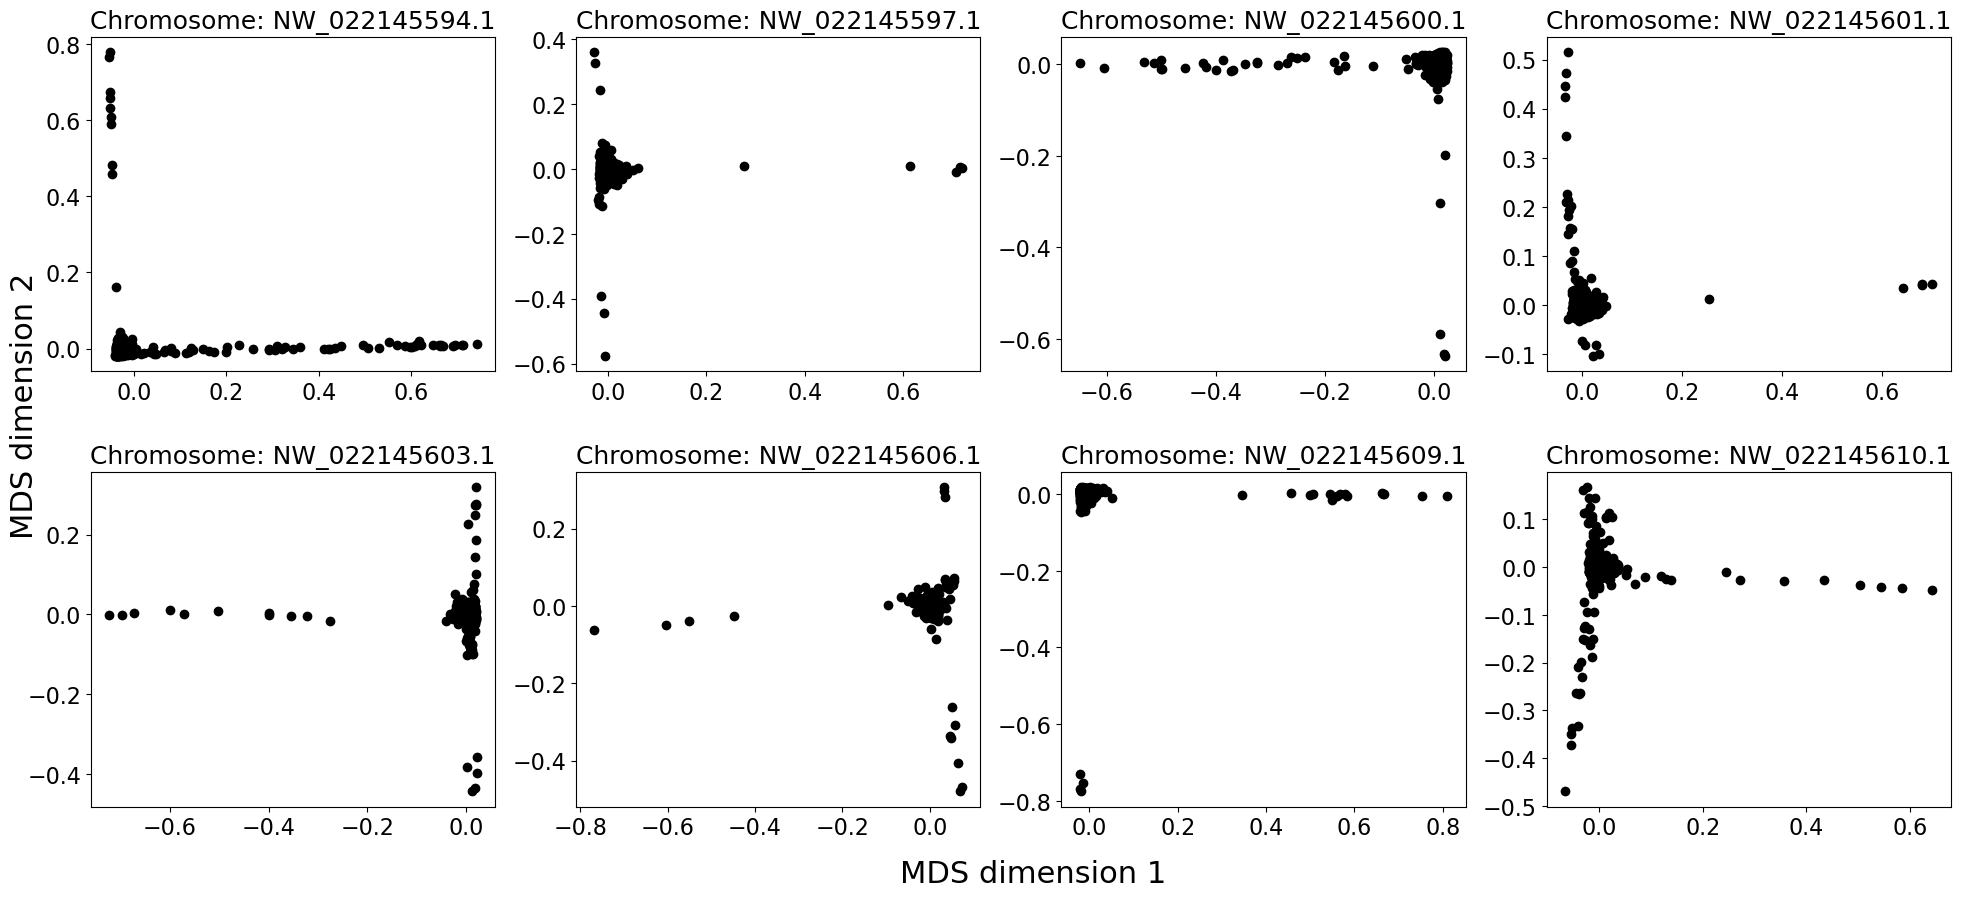

In [32]:
all_chrs=["NW_022145594.1" ,"NW_022145597.1" ,"NW_022145600.1" ,"NW_022145601.1" ,"NW_022145603.1" ,"NW_022145606.1" ,"NW_022145609.1" ,"NW_022145610.1"]


f, axs = plt.subplots(2,4,figsize=(24, 10),sharex=False, sharey=False)

axs=axs.flatten()

counter=0
for c in all_chrs:
    route="~/WGS/inversion_results/lostruct_results/type_" + mtype + "_size_" + str(500) + "_chromosome_" + c
    coords = pd.read_csv(route + "/" + c + ".regions.csv")
    mds = pd.read_csv(route + "/mds_coords.csv")
    lpca = coords.join(mds["MDS1"])
    lpca = lpca.join(mds["MDS2"])
    lpca["pos"] = (lpca["end"]+lpca["start"])/2
    lpca["pos"] = lpca["pos"].astype(int)

    
    axs[counter].scatter(lpca["MDS1"], lpca["MDS2"], color="black")

    axs[counter].set_title(f'Chromosome: {c}', fontsize=18)
    axs[counter].tick_params(axis='both', which='major', labelsize=16)

    #axs[counter][0].ylabel('MDS value')
    #axs[counter][0].xlabel("Genomic position")
    #axs[counter][0].legend()

    counter+=1

plt.text(-0.2, 1.2, 'MDS dimension 2', va='center', rotation='vertical', fontsize=22, transform=axs[4].transAxes)
plt.text(0.8, -0.2, 'MDS dimension 1', va='center', rotation='horizontal', fontsize=22, transform=axs[5].transAxes)

plt.subplots_adjust(wspace=0.2)
plt.subplots_adjust(hspace=0.3)

plt.savefig(f'figs/all_mdss2.pdf', format='pdf')